In [ ]:
#@title Run this to download the dataset
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!unzip -q weather_dataset.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
source_path = "/content/drive/MyDrive/weather_dataset.zip"
destination_path = "/content"

shutil.copy(source_path, destination_path)

'/content/weather_dataset.zip'

In [3]:
!unzip -q weather_dataset.zip

#1) Data Loading and Preprocessing

After exploring the dataset structure, load and preprocess the data according to the following:
- Read the images into memory. For each image also record its label.
- Resize the width and height of each image to (224, 224). All images must have a uniform shape.
- Handle image exeptions that are not strictly RGB.
- Scale the pixel values.
- Stack the images into a single array X of shape (Number of samples, 224, 224, 3).
- Create an array y of labels. One-hot encode the labels.
- Split X and y into training and testing sets.

In [4]:
import os
import cv2
import numpy as np
import pandas as pd

# Define the path to the directory containing the images
dataDir = "/content/weather_dataset"

# Initialize lists to store image paths and labels
imagePaths = []
labels = []

for category in os.listdir(dataDir):
  categoryPath = os.path.join(dataDir , category)
  for image in os.listdir(categoryPath):
    imagePath = os.path.join(categoryPath , image)
    imagePaths.append(imagePath)
    labels.append(category)

firstCol = pd.Series(imagePaths, name= 'ImagePath')
secondCol = pd.Series(labels, name='Category')
df = pd.concat([firstCol, secondCol], axis= 1)

df


ImagePath Category
0        /content/weather_dataset/Rain/rain44.jpg     Rain
1         /content/weather_dataset/Rain/rain4.jpg     Rain
2       /content/weather_dataset/Rain/rain175.jpg     Rain
3       /content/weather_dataset/Rain/rain180.jpg     Rain
4        /content/weather_dataset/Rain/rain85.jpg     Rain
...                                           ...      ...
1120  /content/weather_dataset/Shine/shine190.jpg    Shine
1121  /content/weather_dataset/Shine/shine222.jpg    Shine
1122  /content/weather_dataset/Shine/shine122.jpg    Shine
1123   /content/weather_dataset/Shine/shine37.jpg    Shine
1124   /content/weather_dataset/Shine/shine41.jpg    Shine

[1125 rows x 2 columns]

In [5]:
len(imagePaths)



1125

In [6]:
#Resize images and store them in array
resizedImages = []
newLabels = []
corruptCount = 0
for i in range(len(imagePaths)):
  img = cv2.imread(imagePaths[i])
  if img is None: #To handle images that are not RGB
    corruptCount += 1
  else:
    resizedImg = cv2.resize(img , (244,244))
    resizedImages.append(resizedImg)
    newLabels.append(labels[i])

In [7]:
print("Number of corrupt images = " , corruptCount)
print("Number of images , labels =" , len(resizedImages) , len(newLabels))
print("New size of each image = " , resizedImages[0].shape)

Number of corrupt images =  2
Number of images , labels = 1123 1123
New size of each image =  (244, 244, 3)


In [8]:
scaledImages = []
for img in resizedImages:
  scaledImages.append(img/255)


In [9]:
X = np.stack(scaledImages, axis=0)
X.shape

(1123, 244, 244, 3)

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()

#Now we convert each category to an integer: 0 for cloudy , 1 for rain , 2 for shine ...
integer_encoded = label_encoder.fit_transform(newLabels)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)  # Reshape for one-hot encoding
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#Now we have an array of dimension 4 for each entry for example [0 , 1 , 0 , 0] indicates rain
Y = onehot_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
#Splitting Data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=420)

#2) Data Exploration

Explor the dataset by displaying a number of images along with their labels.

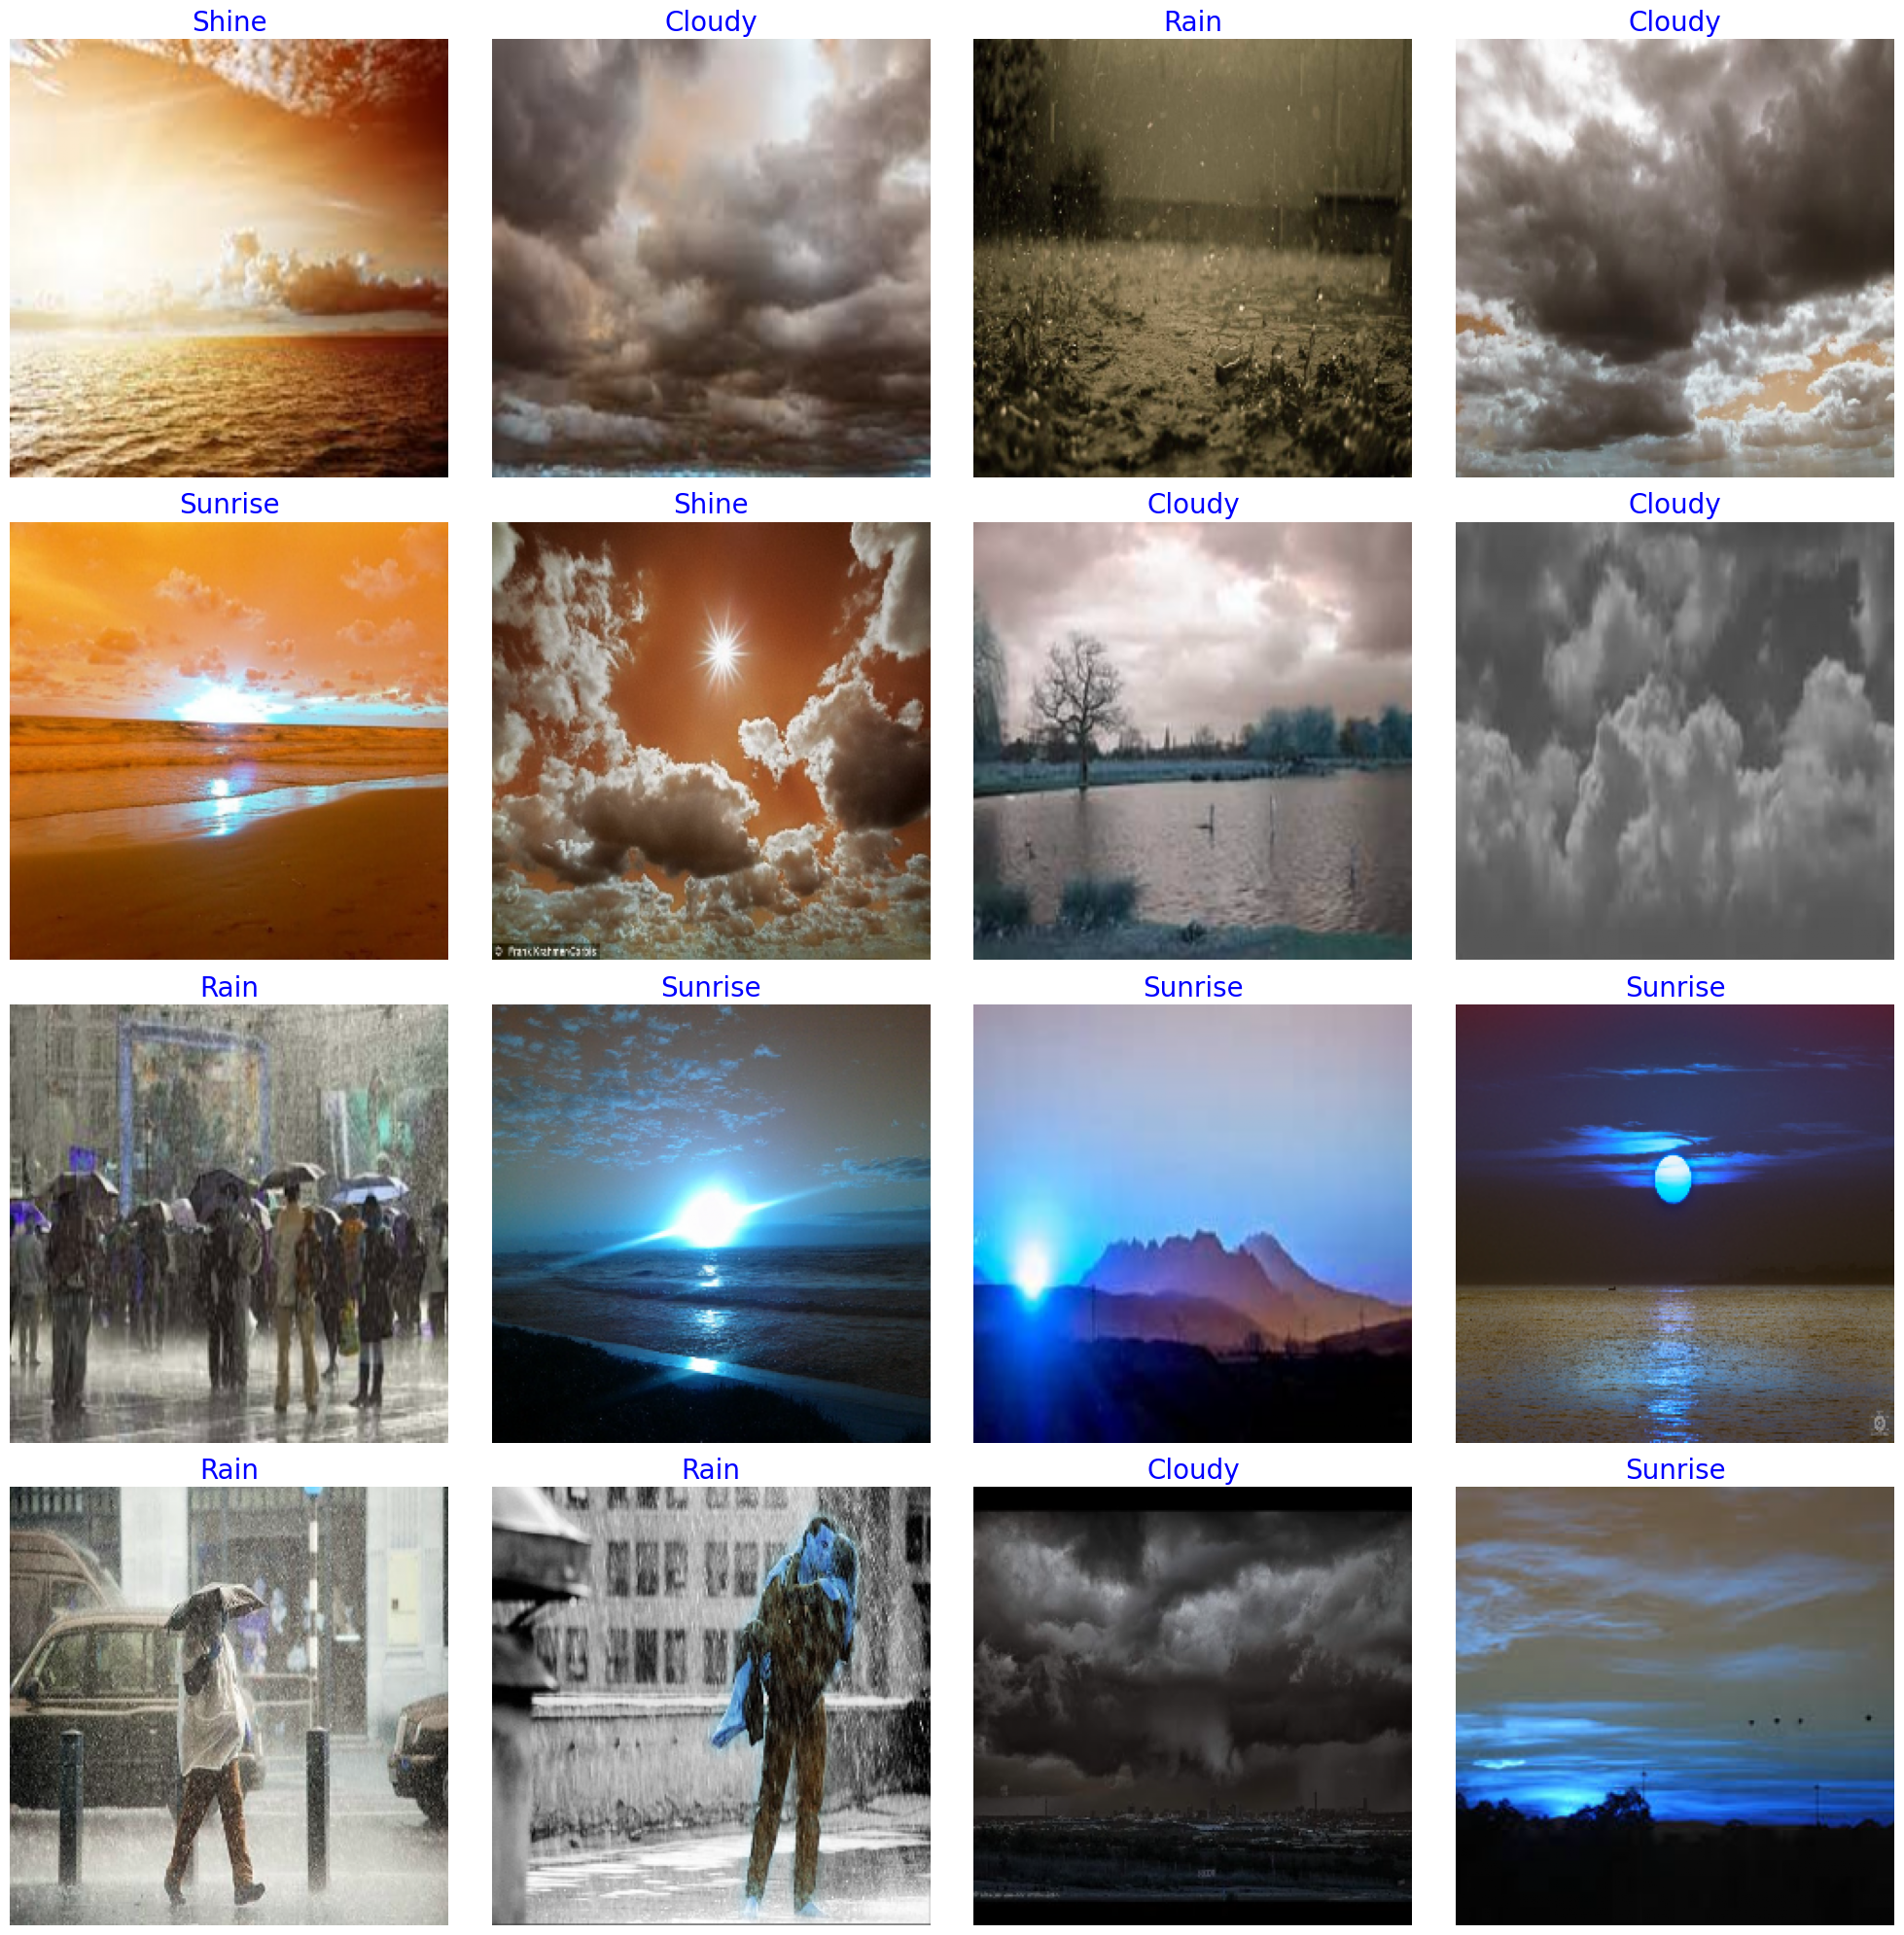

In [12]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    index = random.randint(0 , 1123)
    image = X[index]
    plt.imshow(image)
    class_name = newLabels[index]
    plt.title(class_name, color= 'blue', fontsize= 20)
    plt.axis('off')
plt.tight_layout()
plt.show()

#3) Neural Network

- Build a fully connected neural network.
- Print the network's architecture.
- Train it on the data and show the training and validation loss curves.
- Play with the different hyperparameters (number of layer, number of neurons, optimizer, regularization, epochs, batch size...) until you obtain a satisfactory performance.

In [13]:
y_train.shape


(898, 4)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.Flatten(input_shape=(244, 244, 3)))  # Flatten the input images
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))  # First fully connected layer
model.add(layers.Dense(64, activation='relu'))  # Second fully connected layer
model.add(layers.Dense(4, activation='softmax'))  # Output layer with 4 units (for your 4 classes)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Epoch 1/100
23/23 [==============================] - 7s 75ms/step - loss: 35.3502 - accuracy: 0.4011 - val_loss: 7.5532 - val_accuracy: 0.5167
Epoch 2/100
23/23 [==============================] - 1s 40ms/step - loss: 8.7359 - accuracy: 0.5084 - val_loss: 7.6238 - val_accuracy: 0.6111
Epoch 3/100
23/23 [==============================] - 1s 44ms/step - loss: 4.2593 - accuracy: 0.6588 - val_loss: 4.2852 - val_accuracy: 0.6389
Epoch 4/100
23/23 [==============================] - 1s 49ms/step - loss: 4.1128 - accuracy: 0.6435 - val_loss: 4.7897 - val_accuracy: 0.5722
Epoch 5/100
23/23 [==============================] - 1s 56ms/step - loss: 2.5018 - accuracy: 0.6950 - val_loss: 2.1011 - val_accuracy: 0.6944
Epoch 6/100
23/23 [==============================] - 1s 49ms/step - loss: 0.9356 - accuracy: 0.7981 - val_loss: 0.9431 - val_accuracy: 0.7222
Epoch 7/100
23/23 [==============================] - 1s 40ms/step - loss: 1.1229 - accuracy: 0.7521 - val_loss: 1.2036 - val_accuracy: 0.7167
Epoch

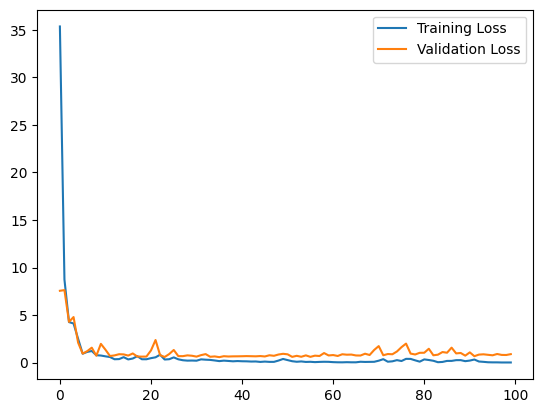

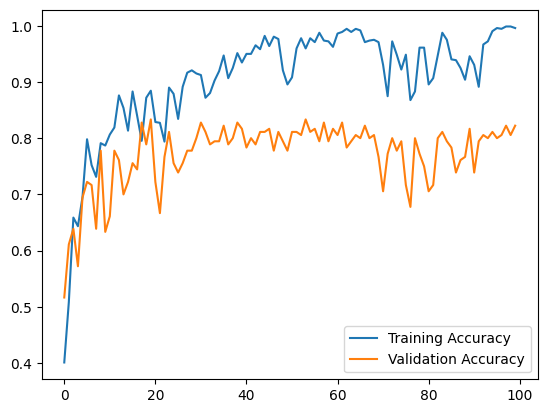

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


- Compute the following evaluation metrics on the test set: accuracy, precision, recall and F1-score.

In [16]:
from sklearn.metrics import classification_report
from keras.utils import to_categorical

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)
y_pred_onehot = to_categorical(y_pred_classes, num_classes=4)

report = classification_report(y_test, y_pred_onehot, target_names=['Cloudy', 'Rain', 'Shine', 'Sunrise'])

print(report)

8/8 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

      Cloudy       0.81      0.78      0.79        54
        Rain       0.89      0.68      0.77        37
       Shine       0.81      0.97      0.88        58
     Sunrise       0.97      0.97      0.97        76

   micro avg       0.88      0.88      0.88       225
   macro avg       0.87      0.85      0.85       225
weighted avg       0.88      0.88      0.87       225
 samples avg       0.88      0.88      0.88       225



#4) Convolutional Neural Network

- Repeat the same steps as Question 3 but using a convolutional neural network.

In [18]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adamax

modelCnn = Sequential()
modelCnn.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(244,244,3)))
modelCnn.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
modelCnn.add(MaxPooling2D(2,2))

modelCnn.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
modelCnn.add(MaxPooling2D(2,2))

modelCnn.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
modelCnn.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
modelCnn.add(MaxPooling2D(2,2))

modelCnn.add(Conv2D(256, kernel_size=(4, 4), padding='same', activation='relu'))
modelCnn.add(Conv2D(256, kernel_size=(4, 4), padding='same', activation='relu'))
modelCnn.add(MaxPooling2D(2,2))

modelCnn.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
modelCnn.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
modelCnn.add(MaxPooling2D(3,3))

modelCnn.add(Flatten())

modelCnn.add(Dense(512,activation = "relu"))
modelCnn.add(Dropout(.5))
modelCnn.add(Dense(256,activation = "relu"))
modelCnn.add(Dropout(.45))
modelCnn.add(Dense(4,activation = "softmax"))

modelCnn.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
modelCnn.summary()

history2 = modelCnn.fit(X_train, y_train, epochs=100, validation_split=0.2)

test_loss, test_accuracy = modelCnn.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')







Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 244, 244, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 244, 244, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 122, 122, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 61, 61, 128)      

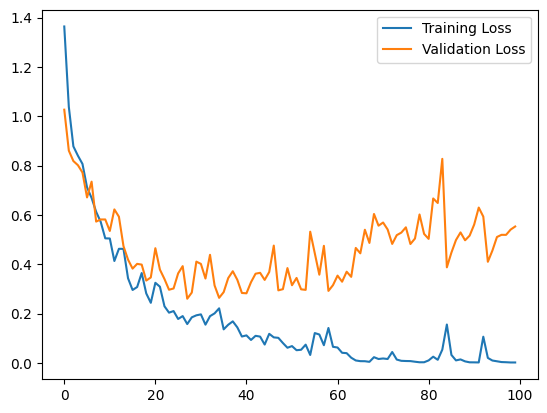

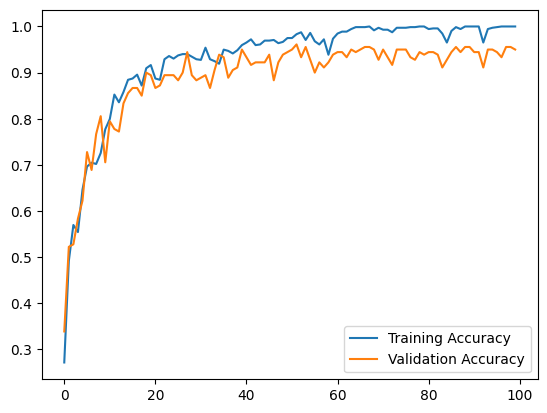

In [19]:
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import classification_report
from keras.utils import to_categorical

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)
y_pred_onehot = to_categorical(y_pred_classes, num_classes=4)

report = classification_report(y_test, y_pred_onehot, target_names=['Cloudy', 'Rain', 'Shine', 'Sunrise'])

print(report)

8/8 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

      Cloudy       0.78      0.78      0.78        54
        Rain       0.84      0.73      0.78        37
       Shine       0.84      0.91      0.88        58
     Sunrise       0.97      0.97      0.97        76

   micro avg       0.87      0.87      0.87       225
   macro avg       0.86      0.85      0.85       225
weighted avg       0.87      0.87      0.87       225
 samples avg       0.87      0.87      0.87       225



#5) Model Inference

- Download an image from the Internet and use your model to recognize the weather in the image.

1/1 [==============================] - 0s 191ms/step
Predicted Class: Shine


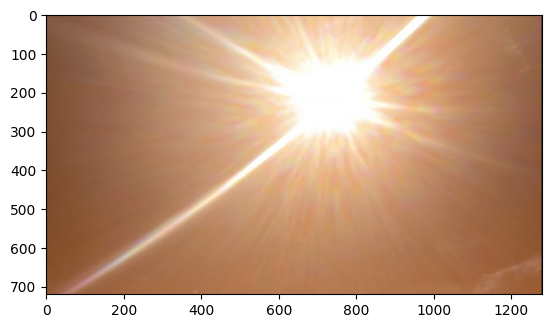

In [22]:
import cv2
import numpy as np

Categories = ["Cloudy" , "Rain" , "Shine" , "Sunrise"]
# First resize and rescale both
def reScaleSize(img):
    resizeImg = cv2.resize(img, (244, 244))
    rescaleImg = resizeImg / 255
    return rescaleImg

# Load the images
image1 = cv2.imread("shinyImg.jpg")
plt.imshow(image1)

# Preprocess the images
image1 = reScaleSize(image1)

# Combine the images into an array
input = np.array([image1])

# Make predictions
predictions = modelCnn.predict(input)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

print("Predicted Class:", Categories[predicted_classes[0]])
